In [89]:
# import model code
from comp5318_assignment1 import models, model_tools, decomposition
import operator as op
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# PCA and requirements

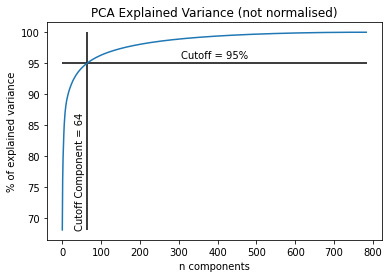

In [68]:
# hyperparameter for component selection
pca_cutoff = 95  # % of variance that is to be explained

# variables for graphing
cutoff_y_axis = True

# load data (and make accessible)
mr = model_tools.ModelRunner()  # handles many things, including data loading
mr.load_data()
Xtr, Ytr = mr.xtr, mr.ytr


# dont normalize as there are many pixels that have nothing in them (and so would be training noise)
pca = decomposition.PCA(normalize=False)

pca.fit(Xtr)
var = pca._metavalues['variances'] / pca._metavalues['variances'].sum() * 100

cutoff_component = np.argmax(np.cumsum(var) > pca_cutoff)

miny = np.min(np.cumsum(var)) if cutoff_y_axis else 0

plt.plot(np.cumsum(var))
plt.vlines(cutoff_component, miny, 100)
plt.text(cutoff_component -30, miny,
         f"Cutoff Component = {cutoff_component}",
         rotation=90, verticalalignment='bottom')
plt.hlines(pca_cutoff, 0, var.size)
plt.text(var.size/2, pca_cutoff+.5, f'Cutoff = {pca_cutoff}%', verticalalignment='bottom', horizontalalignment='center')
plt.title('PCA Explained Variance (not normalised)')
plt.ylabel('% of explained variance')
plt.xlabel('n components')
plt.show()


The above demonstrates that there is a lot of redundant information in the data. Using only 64 components (a reduction in size of 1-64/784 = 92%) 95% of the data variation can be explained. Below are the first 12 principle components.

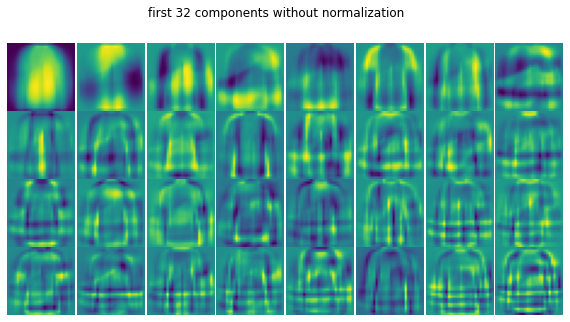

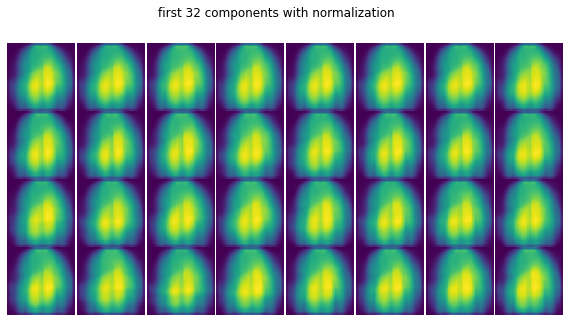

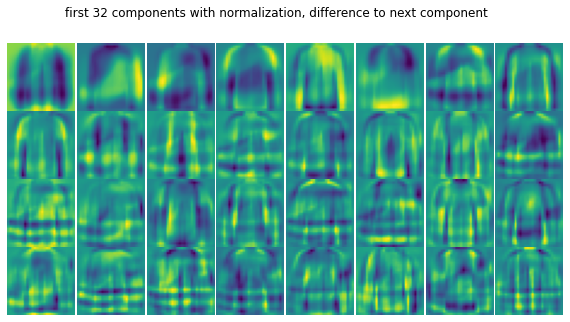

In [71]:
pca_lim = decomposition.PCA(64, normalize=False)
pca_lim.fit(Xtr)
back = pca_lim.inverse_transform(np.eye(64)).reshape(64, 28,28)
plt.figure(figsize=(10, 5)).subplots_adjust(hspace=0, wspace=0)
plt.suptitle('first 32 components without normalization')
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(back[i])
    plt.axis('off')
plt.show()

# difference normalization makes
pca_lim = decomposition.PCA(64, normalize=True)
pca_lim.fit(Xtr)
back = pca_lim.inverse_transform(np.eye(64)).reshape(64, 28,28)
plt.figure(figsize=(10,5)).subplots_adjust(hspace=0, wspace=0)
plt.suptitle('first 32 components with normalization')
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(back[i])
    plt.axis('off')
plt.show()

# to demonstrate they are not the same image

plt.figure(figsize=(10,5)).subplots_adjust(hspace=0, wspace=0)
plt.suptitle('first 32 components with normalization, difference to next component')
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(back[i] - back[i+1])
    plt.axis('off')
plt.show()

# PCA then GNB

In [46]:
model_objs = []
mincomps = 50
maxcomps = 90
step = 2

for components in range(mincomps, maxcomps, step):
    model_objs.append(
        model_tools.Pipeline([
            (f'PCA reduction ({components} components)',
             decomposition.PCA(components, normalize=False)),
            ('GNB Estimator', models.GNB())
        ])
    )

model_runner = model_tools.ModelRunner(*model_objs)

results = model_runner.run_cv(folds=10, verbose=False)

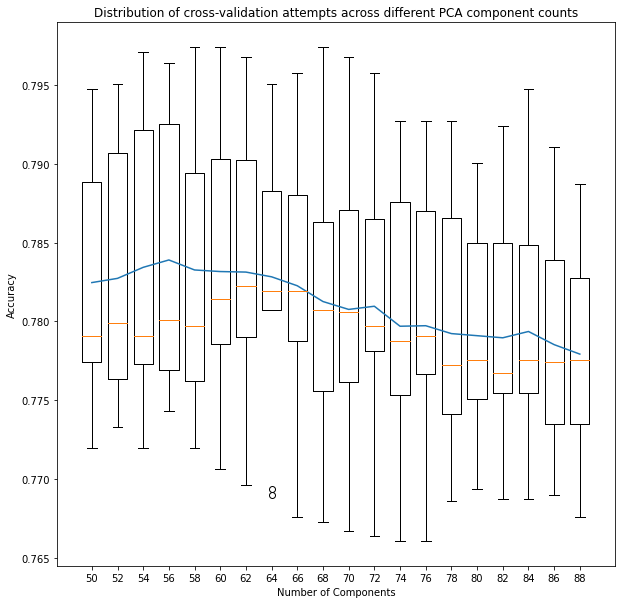

In [47]:
pos = []
treatments = []
means = []
for i, errs in enumerate(np.array(list(results.values()))[:,:,0]):
    comp = mincomps + step * i
    pos.append(comp)
    treatments.append(errs)
    means.append(errs.mean())

fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(pos)
ax.boxplot(treatments, positions=pos, widths=step - .5)
ax.plot(pos, means)
plt.ylabel('Accuracy')
plt.xlabel('Number of Components')
plt.title('Distribution of cross-validation attempts across different PCA component counts')
plt.show()

# PCA then KNN

In [112]:
%%time
model_objs = []
mincomps = 54
stepcomps = 25
maxcomps = 105

ncomps = len(list(range(mincomps, maxcomps, stepcomps)))

mink = 1
maxk = 32
stepk = 6
nk = len(list(range(mink, maxk, stepk)))

print(f'running {nk * ncomps} validations. ({ncomps} component tries by {nk} k tries)')

hyper = []
for components in range(mincomps, maxcomps, stepcomps):
    for k in range(mink, maxk, stepk):
        model_objs.append(
            model_tools.Pipeline([
                (f'PCA reduction ({components} components)',
                 decomposition.PCA(components, normalize=False)),
                (str(m := models.KNN(k=k)), m)
            ])
        )
        hyper.append(dict(k=k, components=components))

model_runner = model_tools.ModelRunner(*model_objs)
results = model_runner.run(verbose=True)

running 18 validations. (3 component tries by 6 k tries)
running Pipeline(PCA reduction (54 components), KNN(k=1, distancefunction=euclidian))
Pipeline(PCA reduction (54 components), KNN(k=1, distancefunction=euclidian)) got (0.7245,)
running Pipeline(PCA reduction (54 components), KNN(k=7, distancefunction=euclidian))
Pipeline(PCA reduction (54 components), KNN(k=7, distancefunction=euclidian)) got (0.752,)
running Pipeline(PCA reduction (54 components), KNN(k=13, distancefunction=euclidian))
Pipeline(PCA reduction (54 components), KNN(k=13, distancefunction=euclidian)) got (0.751,)
running Pipeline(PCA reduction (54 components), KNN(k=19, distancefunction=euclidian))
Pipeline(PCA reduction (54 components), KNN(k=19, distancefunction=euclidian)) got (0.7445,)
running Pipeline(PCA reduction (54 components), KNN(k=25, distancefunction=euclidian))
Pipeline(PCA reduction (54 components), KNN(k=25, distancefunction=euclidian)) got (0.7465,)
running Pipeline(PCA reduction (54 components), K

In [107]:
plotv = []
for h, accuracy in zip(hyper, results.values()):
    plotv.append([h['k'], h['components'], accuracy[0]])
pv = np.array(plotv)
pvr = pv.reshape(ncomps, nk, 3)

fig = plt.figure(figsize=(10,10))
if True:
    ax = fig.add_subplot(111, projection='3d')

    #ax.plot_trisurf(*pv.T, antialiased=True, linewidth=20)
    #ax.plot_wireframe(*pv.reshape(3, 7, 3).T)
    ax.contour(*pvr.T, zdir='y')
    ax.contour(*pvr.T, zdir='x')
    ax.contourf(*pv.reshape(ncomps, nk, 3).T, 15, zdir='z', offset=np.min(pvr.T[2]))
    ax.set_zlabel('Accuracy')
elif True:
    plt.contour(*pvr.T)
plt.xlabel('Number of PCA components')
plt.ylabel('Number of neighbours')
plt.title('Pipeline(PCA, KNN) performance over PCA component count and KNN neighbour count')
plt.show()

<ipython-input-107-988ef482046b>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pv = np.array(plotv)


ValueError: cannot reshape array of size 60 into shape (5,6,3)

# NMF and requirements

In [41]:
# components list to try
components_list = [60]

# load data (and make accessible)
mr = model_tools.ModelRunner()  # handles many things, including data loading
mr.load_data()
Xtr, Ytr = mr.xtr, mr.ytr

# dont re-train
try:
    model_objs = []
except NameError:
    model_objs = []

for c in components_list:
    if c in set(map(op.itemgetter(0), model_objs)):
        pass
    else:
        m = decomposition.NMF(c, max_iter=100)
        print('fitting model', c)
        m.fit(Xtr)
        model_objs.append((c, m))
        print('done')
model_objs = sorted(model_objs, key=op.itemgetter(0))

fitting model 60
done


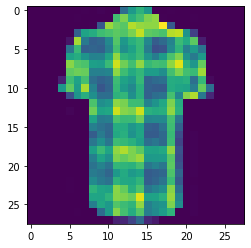

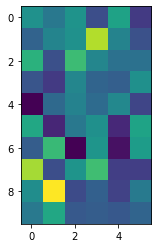

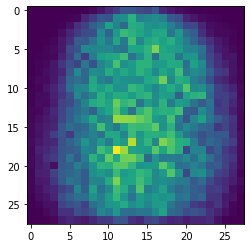

In [45]:
m = model_objs[0][1]
plt.imshow(Xtr[0].reshape(28,28))
plt.show()
plt.imshow(m.transform(Xtr[0][None])[0].reshape(10, 6))
plt.show()
plt.imshow(m.inverse_transform(m.transform(Xtr[0][None]))[0].reshape(28,28))

plt.show()

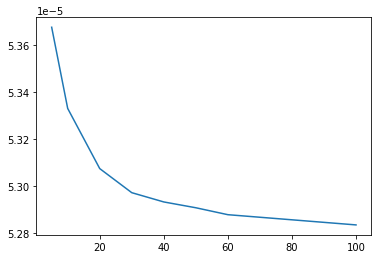

In [6]:
losses = []
for c, m in model_objs:
    losses.append([c, m.get_metavalues()['training_loss'][-1] / np.product(Xtr.shape)])
losses = np.array(losses)
plt.plot(*losses.T)
plt.show()

In [7]:
nmf_gnb = model_tools.Pipeline([
    ('NMF 100', decomposition.NMF(100, max_iter=100)),
    ('gnb', models.KNN(40))
])
nmf_gnb.fit(Xtr, Ytr)

In [80]:
gnb_models = []
meta = []
for n in [10, 100, 200, 300, 400, 500, 600]:
    gnb_models.append(
        model_tools.Pipeline(
            [
                ('reduction', decomposition.NMF(n)),
                (f'gnb{n}', models.GNB())
            ]
        )
    )
    meta.append({'n': n})

mr = model_tools.ModelRunner(*gnb_models)
gnb_res = mr.run_cv(verbose=True)

10
100
200
300
400
500
600
running Pipeline(reduction, gnb10)
running fold #1     
running fold #2     
running fold #3     
running fold #4     
running fold #5     
running fold #6     
running fold #7     
running fold #8     
running fold #9     
running fold #10     
running Pipeline(reduction, gnb100)
running fold #1     
running fold #2     
running fold #3     
running fold #4     
running fold #5     
running fold #6     
running fold #7     
running fold #8     
running fold #9     
running fold #10     
running Pipeline(reduction, gnb200)
running fold #1     
running fold #2     
running fold #3     
running fold #4     
running fold #5     
running fold #6     
running fold #7     
running fold #8     
running fold #9     
running fold #10     
running Pipeline(reduction, gnb300)
running fold #1     
running fold #2     
running fold #3     
running fold #4     
running fold #5     
running fold #6     
running fold #7     
running fold #8     
running fold #9     
running 

In [101]:
gnb_res
dat = []
for (k, v), m in zip(gnb_res.items(), meta):
    dat.append(dict(name=k, mean=v.mean(), sdl=-v.std() + v.mean(), sdh=v.std() + v.mean(), n=m['n']))
gnb_df = pd.DataFrame(dat)

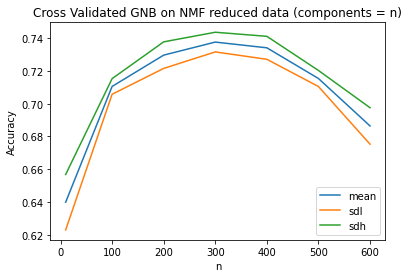

In [105]:
ax = gnb_df.plot('n', 'mean', ylabel='Accuracy', title='Cross Validated GNB on NMF reduced data (components = n)')
gnb_df.plot('n', 'sdl', ax=ax)
gnb_df.plot('n', 'sdh', ax=ax)